## 📁 Random Forest - Base Enriquecida

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Lê o arquivo Excel
df = pd.read_excel('dados_UFV_comp_enriquecida_tratados.xlsx', engine='openpyxl')

# Visualiza as primeiras linhas
df.head()

,Ano_Nascimento,Sexo,Campus,Curso,UF_Nascimento,Admissao,Saida,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,...,Confraternizacao,Disciplina_Introducao,Apadrinhamento_Calouros,Acompanhamento_Academico_Grupo,Encontro_Representacao_Discente,Encontro_Empresa_Junior,Campus_Tour,Trilha_Ecologica,Desenvolvimento_Supervisionado_Projetos,Visita_Tecnica
0,1996,1,0,0,0,0,0,0,1,671,...,0,1,0,0,0,0,0,0,0,0
1,1996,0,0,0,0,1,1,1,9,683,...,1,1,0,0,0,0,0,0,0,0
2,1982,1,0,0,0,2,2,0,9,706,...,1,1,0,0,0,0,0,0,0,0
3,1993,1,0,0,1,3,3,0,0,629,...,0,1,0,0,0,0,0,0,0,0
4,1996,1,0,0,0,0,4,1,9,629,...,0,1,0,0,0,0,0,0,0,0


### 4️⃣ Random Forest

#### Considerando todas as 4 classes:

##### Sem validação cruzada

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.multiclass import unique_labels
import numpy as np

# Separar features (X) e target (y)
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Fazer predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Matriz de probabilidades preditas para todas as classes

# Avaliar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

# Exibir resultados
print("Métricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#-------------------------------------------------------------------------------
# Calcular Especificidade
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Mostrar especificidade por classe
print("\nEspecificidade por classe:")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# Calcular média ponderada da especificidade
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Métricas de Avaliação:
Accuracy: 0.9153
Precision: 0.9199
Recall: 0.9153
F1 Score: 0.9154
AUC: 0.9798

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       348
           1       0.83      0.94      0.88       178
           2       1.00      0.74      0.85        39
           3       0.95      0.95      0.95        84

    accuracy                           0.92       649
   macro avg       0.93      0.89      0.90       649
weighted avg       0.92      0.92      0.92       649


Especificidade por classe:
0: 0.94
1: 0.93
2: 1.00
3: 0.99

Especificidade média ponderada: 0.95


##### Com validação cruzada

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier  # <-- alterado aqui
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, make_scorer
)
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)  # <-- alterado aqui

# 5. Definir métricas para validação cruzada
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc_ovr_weighted': make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
}

# 6. Validação cruzada nos 80% (treino/validação)
cv_results = cross_validate(
    model,
    X_train,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 7. Calcular média das métricas
metric_keys = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

folds_data = []
for i in range(len(cv_results["test_accuracy"])):
    row = [i + 1] + [round(cv_results[f"test_{key}"][i], 3) for key in metric_keys]
    folds_data.append(row)

mean_row = ["Mean"] + [round(np.mean(cv_results[f"test_{key}"]), 3) for key in metric_keys]
folds_data.append(mean_row)

results_df = pd.DataFrame(folds_data, columns=["#", *metric_labels])
print(results_df)

#-------------------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
# 8. Treinar com os 80% e testar nos 20%
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# 10. Calcular especificidade por classe
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# 11. Exibir especificidade por classe
print("\nEspecificidade por classe (base de teste):")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# 12. Calcular especificidade média ponderada (pelo y_test)
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

      #  Accuracy  Precision  Recall     F1    AUC
0     1     0.908      0.912   0.908  0.908  0.979
1     2     0.923      0.924   0.923  0.923  0.982
2     3     0.927      0.930   0.927  0.926  0.982
3     4     0.929      0.930   0.929  0.929  0.986
4     5     0.931      0.933   0.931  0.931  0.981
5  Mean     0.923      0.926   0.923  0.924  0.982

Especificidade por classe (base de teste):
0: 0.93
1: 0.94
2: 1.00
3: 1.00

Especificidade média ponderada: 0.94


##### Importância das features

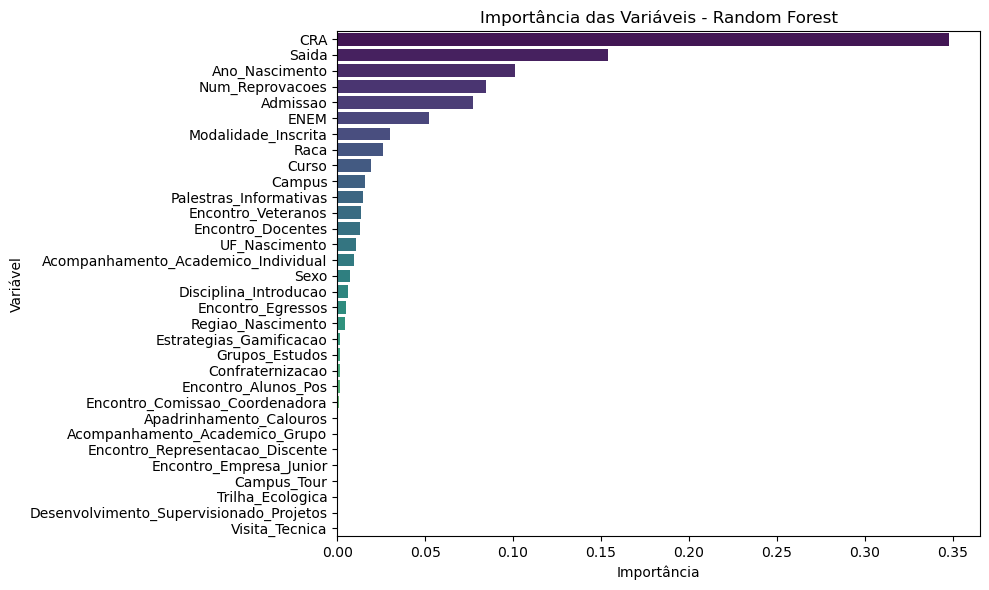

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # <-- Alterado
from sklearn.preprocessing import LabelEncoder

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)  # <-- Alterado

# 5. Ajustar o modelo com os dados de treino
model.fit(X_train, y_train_encoded)  # AQUI o modelo é treinado

# IMPORTÂNCIA DAS FEATURES
importances = model.feature_importances_
features = X.columns

# Organizar em dataframe para facilitar visualização
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df, hue="Feature", palette="viridis", legend=False)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [5]:
# Exibir os valores em uma célula separada
print(feat_df)

                                    Feature  Importance
11                                      CRA    0.348171
6                                     Saida    0.154092
0                            Ano_Nascimento    0.101288
9                           Num_Reprovacoes    0.084404
5                                  Admissao    0.077093
8                                      ENEM    0.052200
7                       Modalidade_Inscrita    0.030143
10                                     Raca    0.026171
3                                     Curso    0.019110
2                                    Campus    0.015812
18                   Palestras_Informativas    0.014493
20                       Encontro_Veteranos    0.013560
19                        Encontro_Docentes    0.012776
4                             UF_Nascimento    0.010710
13      Acompanhamento_Academico_Individual    0.009790
1                                      Sexo    0.007135
23                    Disciplina_Introducao    0

#### Considerando apenas **Evasão** ou **Não Evasão**

In [6]:
# Criando a nova coluna 'Evasao'
df['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].astype(int)
df['Evasao'] = df['Situacao_Aluno_Agrupada'].apply(lambda x: 1 if x == 0 else 0)

In [7]:
# Quantidade de cada valor da nova coluna 'Evasao'
df['Evasao'].value_counts()

Evasao
1    1735
0    1510
Name: count, dtype: int64

In [8]:
# Validação dos valores
df[['Situacao_Aluno_Agrupada', 'Evasao']]

,Situacao_Aluno_Agrupada,Evasao
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
3240,0,1
3241,3,0
3242,0,1
3243,3,0


##### Sem validação cruzada e sem ajustes de parâmetros (resultado padrão)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

# Separar features (X) e target (y)
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])  # remove ambas do X
y = df["Evasao"]  # variável alvo binária

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Fazer predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probabilidade da classe 1 (evasão)

# Avaliar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

# Exibir resultados
print("Métricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#-------------------------------------------------------------------------------
# Calcular Especificidade
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Mostrar especificidade por classe
print("\nEspecificidade por classe:")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# Calcular média ponderada da especificidade
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Métricas de Avaliação:
Accuracy: 0.9137
Precision: 0.9169
Recall: 0.9137
F1 Score: 0.9138
AUC: 0.9723

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       301
           1       0.95      0.88      0.92       348

    accuracy                           0.91       649
   macro avg       0.91      0.92      0.91       649
weighted avg       0.92      0.91      0.91       649


Especificidade por classe:
0: 0.88
1: 0.95

Especificidade média ponderada: 0.92


##### Com validação cruzada e com ajustes de parâmetros (Grid Search CV)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)
import numpy as np

# Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# Treinar/testar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid de parâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# GridSearch
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinar
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Previsões
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

print("\nMétricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#-------------------------------------------------------------------------------
# Especificidade
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

print("\nEspecificidade por classe:")
for cls, spec in zip(best_model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Melhores parâmetros encontrados:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Métricas de Avaliação:
Accuracy: 0.9199
Precision: 0.9226
Recall: 0.9199
F1 Score: 0.9200
AUC: 0.9744

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       301
           1       0.96      0.89      0.92       348

    accuracy                           0.92       649
   macro avg       0.92      0.92      0.92       649
weighted avg       0.92      0.92      0.92       649


Especificidade por classe:
0: 0.89
1: 0.95

Especificidade média ponderada: 0.92


##### Com validação cruzada e sem ajustes de parâmetros 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier  # <-- alterado aqui
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, make_scorer
)
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)  # <-- alterado aqui

# 5. Definir métricas para validação cruzada
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc_ovr_weighted': make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
}

# 6. Validação cruzada nos 80% (treino/validação)
cv_results = cross_validate(
    model,
    X_train,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 7. Calcular média das métricas
metric_keys = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

folds_data = []
for i in range(len(cv_results["test_accuracy"])):
    row = [i + 1] + [round(cv_results[f"test_{key}"][i], 3) for key in metric_keys]
    folds_data.append(row)

mean_row = ["Mean"] + [round(np.mean(cv_results[f"test_{key}"]), 3) for key in metric_keys]
folds_data.append(mean_row)

results_df = pd.DataFrame(folds_data, columns=["#", *metric_labels])
print(results_df)

#-------------------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
# 8. Treinar com os 80% e testar nos 20%
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# 10. Calcular especificidade por classe
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# 11. Exibir especificidade por classe
print("\nEspecificidade por classe (base de teste):")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# 12. Calcular especificidade média ponderada (pelo y_test)
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

      #  Accuracy  Precision  Recall     F1    AUC
0     1     0.935      0.935   0.935  0.935  0.977
1     2     0.929      0.931   0.929  0.929  0.977
2     3     0.921      0.926   0.921  0.921  0.970
3     4     0.919      0.920   0.919  0.919  0.974
4     5     0.927      0.930   0.927  0.927  0.980
5  Mean     0.926      0.929   0.926  0.926  0.976

Especificidade por classe (base de teste):
0: 0.91
1: 0.96

Especificidade média ponderada: 0.94


##### Importância das Features

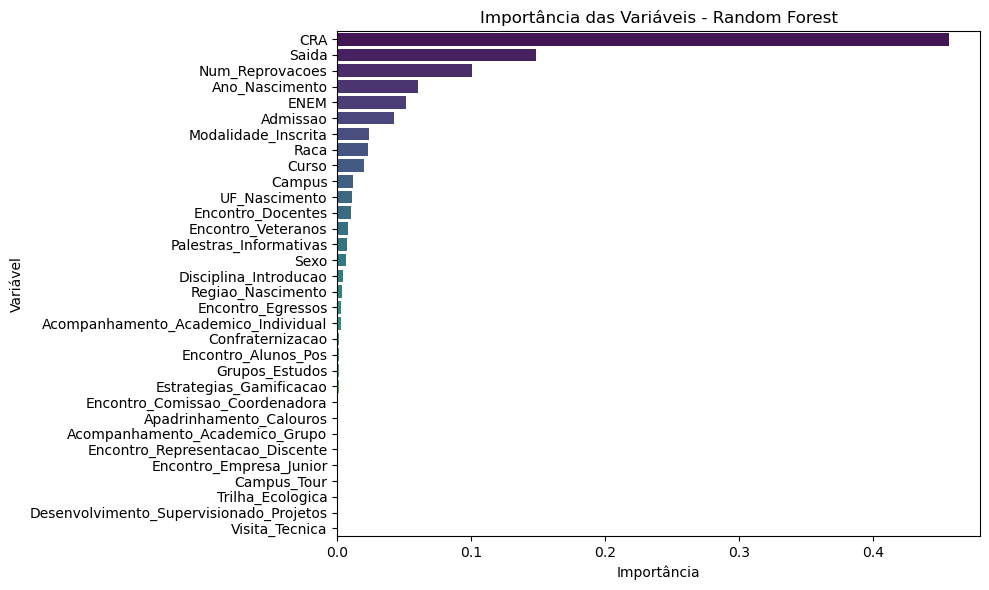

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # <-- Alterado
from sklearn.preprocessing import LabelEncoder

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)  # <-- Alterado

# 5. Ajustar o modelo com os dados de treino
model.fit(X_train, y_train_encoded)  # AQUI o modelo é treinado

# IMPORTÂNCIA DAS FEATURES
importances = model.feature_importances_
features = X.columns

# Organizar em dataframe para facilitar visualização
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df, hue="Feature", palette="viridis", legend=False)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [13]:
# Exibir os valores em uma célula separada
print(feat_df)

                                    Feature  Importance
11                                      CRA    0.457075
6                                     Saida    0.148398
9                           Num_Reprovacoes    0.100869
0                            Ano_Nascimento    0.060216
8                                      ENEM    0.051018
5                                  Admissao    0.042136
7                       Modalidade_Inscrita    0.023506
10                                     Raca    0.022623
3                                     Curso    0.019881
2                                    Campus    0.012079
4                             UF_Nascimento    0.010644
19                        Encontro_Docentes    0.010122
20                       Encontro_Veteranos    0.008346
18                   Palestras_Informativas    0.007436
1                                      Sexo    0.006749
23                    Disciplina_Introducao    0.004413
12                        Regiao_Nascimento    0